Rank categories: ['Top 10' 'Top 100' 'Top 200' 'Top 50']
Epoch 1/50, Loss: 0.913412, Accuracy: 0.6145
Epoch 2/50, Loss: 0.590240, Accuracy: 0.7466
Epoch 3/50, Loss: 0.549895, Accuracy: 0.7579
Epoch 4/50, Loss: 0.543764, Accuracy: 0.7581
Epoch 5/50, Loss: 0.529605, Accuracy: 0.7630
Epoch 6/50, Loss: 0.526837, Accuracy: 0.7659
Epoch 7/50, Loss: 0.521829, Accuracy: 0.7669
Epoch 8/50, Loss: 0.512120, Accuracy: 0.7660
Epoch 9/50, Loss: 0.520222, Accuracy: 0.7655
Epoch 10/50, Loss: 0.520924, Accuracy: 0.7636
Epoch 11/50, Loss: 0.516791, Accuracy: 0.7657
Epoch 12/50, Loss: 0.514530, Accuracy: 0.7673
Epoch 13/50, Loss: 0.509775, Accuracy: 0.7681
Epoch 14/50, Loss: 0.511681, Accuracy: 0.7674
Epoch 15/50, Loss: 0.509650, Accuracy: 0.7680
Epoch 16/50, Loss: 0.507191, Accuracy: 0.7715
Epoch 17/50, Loss: 0.508413, Accuracy: 0.7696
Epoch 18/50, Loss: 0.506294, Accuracy: 0.7687
Epoch 19/50, Loss: 0.506105, Accuracy: 0.7674
Epoch 20/50, Loss: 0.508771, Accuracy: 0.7691
Epoch 21/50, Loss: 0.502347, Acc

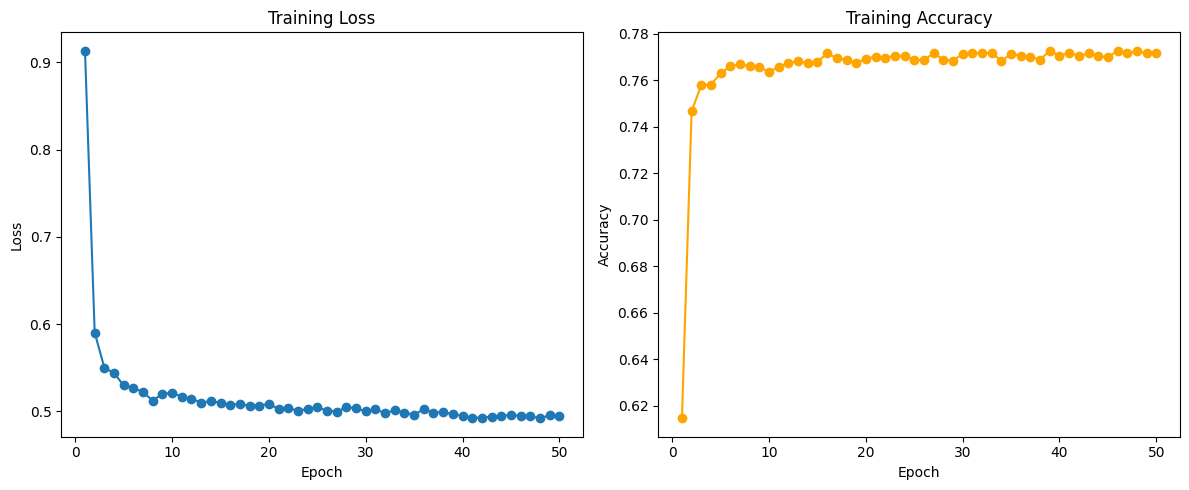

Test Accuracy: 0.8128
Prediction steps (months difference): 9
Category mapping (encoded: avg normalized Hours_watched): {np.int64(0): np.float64(0.19450952789738715), np.int64(1): np.float64(0.005148985476368703), np.int64(2): np.float64(0.0017070464486289494), np.int64(3): np.float64(0.0240167101981871)}
Predicted Rank for 2025.6: Top 200


/Users/lcheng/Desktop/171 final/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# 1. Data Loading and Preprocessing
# -----------------------------
df = pd.read_csv("data.csv")

# Sort by Year and Month to ensure correct chronological order
df = df.sort_values(by=["Year", "Month"]).reset_index(drop=True)

# Encode the 'rank_category' column (e.g., ['Top 10', 'Top 100', 'Top 200', 'Top 50'])
label_encoder = LabelEncoder()
df["rank_category_encoded"] = label_encoder.fit_transform(df["rank_category"])
num_classes = len(label_encoder.classes_)
print("Rank categories:", label_encoder.classes_)

# Select "Hours_watched" as the input feature and convert it to float
data_feature = df[["Hours_watched"]].values.astype(float)
data_target = df["rank_category_encoded"].values

# Normalize Hours_watched
scaler = MinMaxScaler(feature_range=(0, 1))
data_feature_scaled = scaler.fit_transform(data_feature)

# Construct time-series data: Use the past `seq_length` months as input, target is the rank_category of the next month
def create_sequences(features, labels, seq_length):
    sequences, targets = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i+seq_length])
        targets.append(labels[i+seq_length])
    return np.array(sequences), np.array(targets)

# Set sequence length, e.g., 12 months
seq_length = 12
X, y = create_sequences(data_feature_scaled, data_target, seq_length)

# Split into training and test sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# 2. Define LSTM Classification Model
# -----------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, num_classes=4):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Take the output from the last time step and pass it through a fully connected layer
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_size=1, hidden_size=50, num_layers=2, num_classes=num_classes).to(device)

# -----------------------------
# 3. Train the Model and Record Training Process
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.4f}')

# Plot Training Loss and Accuracy
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Evaluate the Model on Test Data
# -----------------------------
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total_test += batch_y.size(0)
        correct_test += (predicted == batch_y).sum().item()

test_accuracy = correct_test / total_test
print("Test Accuracy: {:.4f}".format(test_accuracy))

# -----------------------------
# 5. Predict Future Rank for a Target Month
# -----------------------------
# Target month (e.g., predicting rank for June 2025)
target_year = 2025
target_month = 6

# Retrieve the year and month of the last record in the dataset (assuming the last row is the latest data)
last_year = df['Year'].iloc[-1]
last_month = df['Month'].iloc[-1]
# Calculate the number of months between the last record and the target month
months_diff = (target_year - last_year) * 12 + (target_month - last_month)
print("Prediction steps (months difference):", months_diff)

# Construct category mapping:
# Use the average normalized Hours_watched for each category as its representative value
df['Hours_watched_norm'] = scaler.transform(df[['Hours_watched']])
category_mapping = {}
for cat in np.unique(df['rank_category_encoded']):
    avg_norm = df[df['rank_category_encoded'] == cat]['Hours_watched_norm'].mean()
    category_mapping[cat] = avg_norm
print("Category mapping (encoded: avg normalized Hours_watched):", category_mapping)

# Use the last sequence from X as the initial input, shape (1, seq_length, 1)
last_sequence = X[-1]
last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

predicted_rank = None  # Store the latest predicted category

# Iteratively predict for `months_diff` steps, simulating monthly predictions
for _ in range(months_diff):
    with torch.no_grad():
        outputs = model(last_sequence)
        _, predicted = torch.max(outputs.data, 1)
        predicted_rank = predicted.item()
    # Use the category mapping to get the corresponding average normalized value
    predicted_norm_value = category_mapping[predicted_rank]
    # Create a tensor of shape (1, 1, 1) as the new input value
    predicted_tensor = torch.tensor([[[predicted_norm_value]]], dtype=torch.float32).to(device)
    # Shift the sequence forward and append the new predicted value
    last_sequence = torch.cat((last_sequence[:, 1:, :], predicted_tensor), dim=1)

# Convert predicted category back to original labels
predicted_rank_label = label_encoder.inverse_transform([predicted_rank])[0]
print(f"Predicted Rank for {target_year}.{target_month}: {predicted_rank_label}")


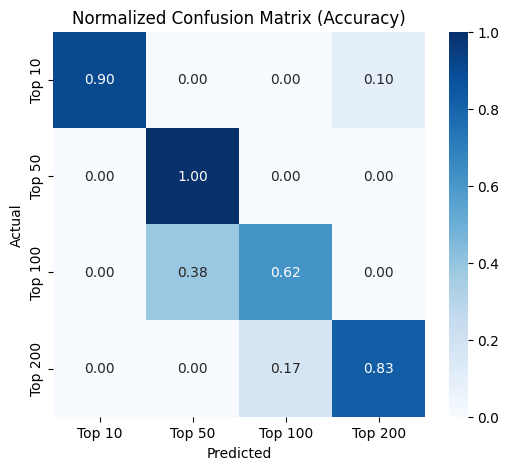

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions for the test set
y_test_pred = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_test_pred.extend(predicted.cpu().numpy())
y_test_pred = np.array(y_test_pred)

# Compute the confusion matrix (absolute counts)
cm = confusion_matrix(y_test, y_test_pred)

# Normalize the confusion matrix: each row is divided by its total count,
# resulting in the accuracy proportion for each class prediction
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define the desired order of categories to display
desired_order = ['Top 10', 'Top 50', 'Top 100', 'Top 200']

# Find the indices of each category in desired_order based on label_encoder.classes_
order_indices = [np.where(label_encoder.classes_ == cls)[0][0] for cls in desired_order]

# Reorder the confusion matrix accordingly
cm_normalized_ordered = cm_normalized[order_indices, :][:, order_indices]

# Plot the heatmap showing the normalized accuracy (e.g., 0.90 means 90%)
plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized_ordered, annot=True, fmt=".2f", cmap='Blues', 
            xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Accuracy)")
plt.show()



         precision    recall  f1-score  support
Top 10    1.000000  0.903846  0.949495    208.0
Top 100   0.871622  0.860000  0.865772   1050.0
Top 200   0.978120  0.936667  0.956945   2100.0
Top 50    0.872274  1.000000  0.931780    840.0


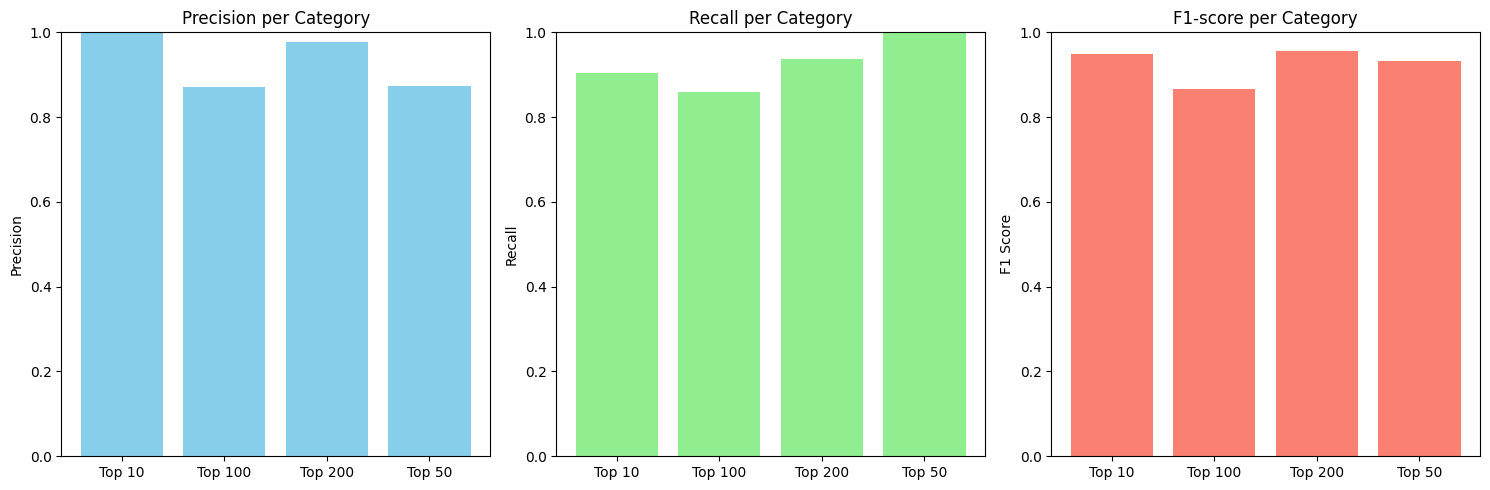

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Compute the classification report and output it as a dictionary
report_dict = classification_report(all_true, all_pred, target_names=categories, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Keep only the category-specific metrics (exclude 'accuracy', 'macro avg', 'weighted avg')
report_df = report_df.loc[categories]
print(report_df)

# Plot bar charts for Precision, Recall, and F1-score
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Precision
ax[0].bar(report_df.index, report_df['precision'], color='skyblue')
ax[0].set_title('Precision per Category')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Precision')

# Recall
ax[1].bar(report_df.index, report_df['recall'], color='lightgreen')
ax[1].set_title('Recall per Category')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Recall')

# F1-score
ax[2].bar(report_df.index, report_df['f1-score'], color='salmon')
ax[2].set_title('F1-score per Category')
ax[2].set_ylim(0, 1)
ax[2].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()



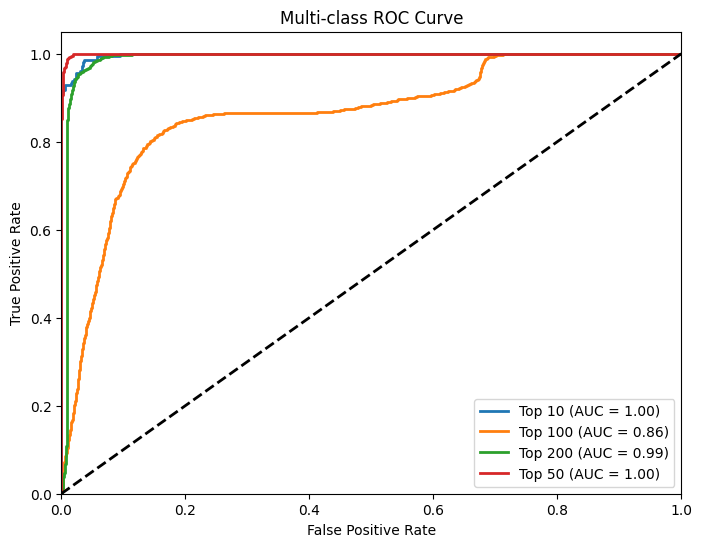

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Predict all test set samples and obtain probability outputs for each class
model.eval()
all_true = []
all_prob = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        prob = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        all_true.extend(batch_y.cpu().numpy())
        all_prob.append(prob.cpu().numpy())

all_prob = np.concatenate(all_prob, axis=0)
all_true = np.array(all_true)

# Binarize true labels for multi-class ROC curve calculation
all_true_binarized = label_binarize(all_true, classes=np.arange(num_classes))

# Compute FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_binarized[:, i], all_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()
